## Multi-layer Perceptron

Network with multiple layers of perceptrons stacked together. A single perceptron is a linear model taking multiple inputs, multiplied with weights, and added to a bias term to produce an output.

$Z = \vec{w} \cdot X + b$

### Dense (Hidden) Layer

A **Dense Layer** is a fully-connected layer of perceptrons:

$f(X) = W \cdot X + \vec{b}$

A **Multi-layer Perceptron** has several dense layers

### Rectified Linear Units (ReLU)

**ReLU** is an activation function which is zero for any values below 0:

$f(x) = max(0, X)$

### Neural Network Training

#### Feed-forward Loop 

Takes an input and generate output for making a prediction

#### Backpropagation Loop

Trains the model by adjusting weights in the layer to lower output loss. Done using backpropagated gradients using the chain rule and optimized using **stochastic gradient descent (SGD)** 

Compute loss gradient using chain rule

$ \frac{\partial loss}{\partial x} = \frac{\partial loss}{\partial layer} * \frac{\partial layer}{\partial x}$

$ \frac{\partial loss}{\partial layer}$ is received as layer input

In [3]:
# Imports
from __future__ import print_function
import numpy as np
np.random.seed(42)

In [4]:
class Layer:
    # Dummy Layer: does nothing
    
    def __init__(self):
        
        pass
    
    def forward(self, input):
        # Take input data of shape[batch, input_units]
        # Returns output data [batch, output_units]
        return input
    
    def backward(self, input, grad_output):
        # Performs a backpropagation step through the layer, w.r.t. given input
        
        # d loss / d layer is received as input, so only need to multiply by d layer / d x
        
        # The layer's parameters need to be updated in d layer / d x
        
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [5]:
# Simple layer that adds nonlinearity to elements in the network
class ReLU(Layer):
    def __init__(self):
        # ReLU layer simply applies elementwise rectified linear unit to all inputs
        pass
    
    def forward(self, input):
        # Apply elementwise ReLU to [batch, input_units] matrix
        relu_forward = np.maximum(0, input)
        return relu_forward
    
    def backward(self, input, grad_output):
        # Compute gradient of loss w.r.t. ReLU input
        relu_grad = input > 0
        return grad_output * relu_grad

### Dense Layer Implementation

Unlike the ReLU nonlinearity, a dense layer actually learns. It applies affine transformation defined as (in vecorized form):

$f(X) = W \cdot X + \vec{b}$, where

X is an object-feature matrix of shape [batch_size, num_features]

W is a weight matrix [num_features, num_outputs]

b is a vector of biases [num_outputs]

#### Xavier Initialization

W and b are initialized during layer creation and updated with each backward loop call.

**Xavier initialization** trains the model to converge faster. Instead of initializing weights with small numbers distributed randomly randomly, it initializes with **mean:** 0 and **variance:** $\frac{2}{\text{# of inputs + # of outputs}}$

#### Backward Loop

Compute gradient w.r.t. weights and biases

$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial dense} * \frac{\partial dense}{\partial x}$,
where $\frac{\partial dense}{\partial x}$ is weights transposed

In [6]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, scale=np.sqrt(2/(input_units+output_units)),
            size=(input_units, output_units))
        self.biases = np.zeros(output_units)
    
    def forward(self, input):
        # input shape: [batch, input_units]
        # output shape: [batch, output units]
        
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        
        # Compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0) * input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Perform a stochastic gradient descent step
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Loss Function

One option is to define a **softmax nonlinearity** on top of the network to predict probabilities and compute loss given predicted probabilities.

But, it's better to compute crossentropy as a function of softmax logits:

$ \text{loss} = -log \frac{e^{a_{correct}}}{\sum_i e^{a_i}} = -a_{correct} + log \sum_i e^{a_i} $

Called **log-softmax** and is better than naive log(softmax(a)) at:

- Better numerical stability
- Easier to get derivative right
- Marginally faster to compute

In [7]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute corssentropy from logits[batch, n_classes] and ids of correct answers
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    # Compute crossentropy gradient from logits[batch, n_classes] and ids of correct answers
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    
    return (-ones_for_answers + softmax) / logits.shape[0]

### Execution

Now to use everything above as a working neural network. Training will be done with the MNIST data of handwritten digits. Keras has the data in numpy array format already.

Using TensorFlow backend.


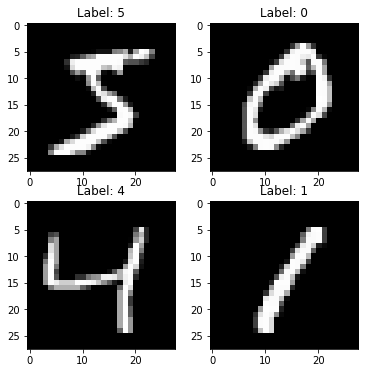

In [8]:
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    
    # Normalize X
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.
    
    # Reserve the last 10,000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [15]:
# Define network as list of layers
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 200))
network.append(ReLU())
network.append(Dense(200, 10))

def forward(network, X):
    # Compute activations of all network layers by applying them sequentially
    # Return a list of activations for each layer
    activations = []
    input = X
    
    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    # Compute network predictions
    # Return indices of largest Logit probability
    
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

def train(network, X, y):
    # First run forward to get all layer activations
    # Then run backward going from last to first layer
    # Finally, all Dense layers will have made one gradient step
    
    # Get layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations # layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute loss and initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index], loss_grad) # grad w.r.t input
        
        return np.mean(loss)

### Training Loop

**Mini-Batch Stochastic Gradient Descent** splits the data into minibatches, feeds each minibatch into the network and updates weights.

Epoch 49
Train accuracy: 0.8667
Val accuracy: 0.8784


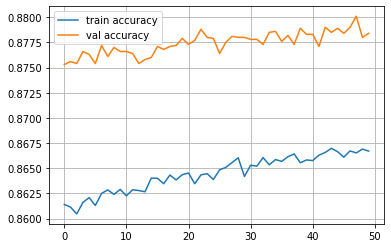

In [18]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        
from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(50):
    
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
        
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("Val accuracy:", val_log[-1])
    
    plt.plot(train_log, label='train accuracy')
    plt.plot(val_log, label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()